In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt
from matplotlib import cm
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn import metrics
from sklearn.base import BaseEstimator
from sklearn.svm import SVC, SVR 
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
import tensorflow as tf

pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [ ]:
cd /Users/pwalesdi/Desktop/GA/NBA_Player_Prediction/Notebooks/

In [2]:
%store -r nba
%store -r improvement
%store -r per_improvement
%store -r second_year_prime

In [3]:
second_year_prime.shape

(490, 44)

In [4]:
second_year_prime.sort_values(by='MP').head(3)

,Player_name,player_id,SEASON,Tm_x,DRAFT_YEAR+1,Draft_team,Pk,Pos,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,College,Yrs,PTS,TRB,AST,FG%,3P%,FT%,PPG,RPG,APG,draft_round,target
208,Jawun Evans,evansja01,2019,OKC,2018.0,PHI,39.0,PG,22,1,1,-38.1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.7,0.0,0.0,0.0,-0.946,-25.2,-13.6,-38.9,0.0,Oklahoma State University,2.0,237.0,96.0,110.0,0.345,0.263,0.776,4.2,1.7,2.0,2.0,0
5590,Marcus Williams,willima04,2009,SAS,2008.0,SAS,33.0,PF,22,2,3,53.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.3,0.0,0.0,0.0,0.517,17.7,-8.5,9.1,0.0,University of Arizona,2.0,14.0,12.0,3.0,0.318,NaN,NaN,1.1,0.9,0.2,2.0,0
3977,Hamady N'Diaye,ndiayha01,2012,WAS,2011.0,MIN,56.0,C,25,3,3,-13.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.9,0.0,0.0,0.0,-0.369,-15.6,-4.8,-20.4,0.0,Rutgers University,3.0,20.0,25.0,3.0,0.467,NaN,0.462,0.6,0.8,0.1,2.0,0


In [5]:
# Creating a data set to do future predictions that can't be completely tested
test_master = second_year_prime.loc[(second_year_prime['DRAFT_YEAR+1'] == 2017) | (second_year_prime['DRAFT_YEAR+1'] == 2018) | (second_year_prime['DRAFT_YEAR+1'] == 2016)]
test_master

,Player_name,player_id,SEASON,Tm_x,DRAFT_YEAR+1,Draft_team,Pk,Pos,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,College,Yrs,PTS,TRB,AST,FG%,3P%,FT%,PPG,RPG,APG,draft_round,target
4,Bam Adebayo,adebaba01,2019,MIA,2018.0,MIA,14.0,C,21,82,1913,17.9,0.623,0.031,0.465,9.2,24.0,16.6,14.2,1.8,3.0,17.1,15.8,3.4,3.4,6.8,0.171,-0.6,3.6,3.0,2.4,University of Kentucky,2.0,1206.0,978.0,285.0,0.550,0.136,0.728,8.0,6.5,1.9,1.0,0
10,Jarrett Allen,allenja01,2019,BRK,2018.0,BRK,22.0,C,20,80,2096,18.5,0.632,0.079,0.489,9.6,24.0,16.8,7.9,1.0,4.5,13.0,15.9,4.4,3.3,7.6,0.175,-0.7,3.2,2.5,2.4,University of Texas at Austin,2.0,1460.0,1060.0,159.0,0.590,0.183,0.732,9.6,7.0,1.0,1.0,0
11,Kadeem Allen,allenka01,2019,NYK,2018.0,BOS,53.0,SG,26,19,416,16.2,0.574,0.255,0.383,2.0,11.1,6.4,28.7,1.9,0.8,13.6,19.6,0.7,0.2,1.0,0.111,0.5,-1.6,-1.1,0.1,University of Arizona,2.0,208.0,62.0,88.0,0.436,0.362,0.778,5.6,1.7,2.4,2.0,0
18,Ike Anigbogu,anigbik01,2019,IND,2018.0,IND,47.0,C,20,3,6,-6.0,0.000,0.000,0.000,18.9,36.2,27.7,19.4,0.0,14.8,25.0,29.1,-0.1,0.0,-0.1,-0.480,-22.5,8.5,-14.0,0.0,University of California Los Angeles,2.0,13.0,12.0,1.0,0.333,NaN,0.833,0.9,0.9,0.1,2.0,0
22,OG Anunoby,anunoog01,2019,TOR,2018.0,TOR,23.0,SF,21,67,1352,9.8,0.544,0.500,0.153,4.8,10.8,7.9,4.7,1.6,1.3,11.3,15.5,0.3,1.7,2.0,0.070,-1.3,0.1,-1.2,0.3,Indiana University,2.0,907.0,381.0,102.0,0.461,0.351,0.605,6.4,2.7,0.7,1.0,0
29,Dwayne Bacon,bacondw01,2019,CHO,2018.0,NOP,40.0,SG,23,43,759,11.7,0.570,0.339,0.179,1.1,11.7,6.3,9.2,0.8,0.6,6.1,16.8,0.9,0.3,1.2,0.073,-1.2,-2.4,-3.5,-0.3,Florida State University,2.0,491.0,213.0,85.0,0.432,0.377,0.761,5.1,2.2,0.9,2.0,0
35,Lonzo Ball,balllo01,2019,LAL,2018.0,LAL,2.0,PG,21,47,1423,11.7,0.487,0.500,0.105,4.0,14.0,9.1,23.8,2.3,1.1,17.8,16.9,-0.2,1.7,1.6,0.052,-0.9,1.5,0.5,0.9,University of California Los Angeles,2.0,993.0,611.0,631.0,0.380,0.315,0.437,10.0,6.2,6.4,1.0,0
51,Jordan Bell,belljo01,2019,GSW,2018.0,CHI,38.0,C,24,68,788,12.9,0.531,0.010,0.214,7.8,16.7,12.5,12.3,1.2,5.4,16.7,13.7,0.5,1.1,1.6,0.096,-3.1,2.8,-0.4,0.3,University of Oregon,2.0,485.0,391.0,178.0,0.570,0.000,0.647,3.9,3.1,1.4,2.0,0
62,Jaron Blossomgame,blossja01,2019,CLE,2018.0,SAS,59.0,SF,25,27,439,10.2,0.510,0.368,0.123,6.3,19.1,12.4,4.2,0.8,1.6,9.0,12.2,0.2,0.1,0.3,0.030,-3.1,-1.5,-4.5,-0.3,Clemson University,1.0,114.0,98.0,13.0,0.443,0.256,0.769,4.2,3.6,0.5,2.0,0
66,Jonah Bolden,boldejo01,2019,PHI,2018.0,PHI,36.0,PF,23,44,639,12.7,0.595,0.593,0.167,8.0,19.0,13.7,8.5,1.3,4.8,17.2,13.8,0.5,0.9,1.4,0.106,-0.8,2.0,1.2,0.5,NaN,1.0,207.0,165.0,40.0,0.494,0.354,0.481,4.7,3.8,0.9,2.0,0


In [6]:
features = [
            'Pk', 
            'Age', 
            'G', 
            'MP', 
            'TS%', 
            '3PAr', 
            'FTr', 
            'ORB%', 
            'DRB%', 
            'TRB%', 
            'AST%', 
            'BLK%', 
            'TOV%', 
            'USG%', 
#             'OWS', 
#             'DWS', 
            'WS', 
            'WS/48', 
            'OBPM', 
            'DBPM', 
            'BPM', 
            'VORP']

In [7]:
y = second_year_prime['target'] # Setting y --> our target variable
X = second_year_prime[features] # Creating our X variables based on the features we want to use to predict target
ss = StandardScaler() # Instantiate a standard scalar
X_sc = ss.fit_transform(X) # Fit and transform our X variable
ros = RandomOverSampler(random_state=0) # Instantiate a random oversampler in order to oversample our training set
X_resampled, y_resampled = ros.fit_resample(X_sc, y) # Fit that oversampler to our X_sc (scaled) and y data
print(sorted(Counter(y_resampled).items())) # Show the balance btw classes

[(0, 448), (1, 448)]


In [ ]:
X.shape

In [8]:
# Train, test, split based on our oversampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=100, test_size=0.25)

In [ ]:
# results = pd.DataFrame(lr.predict(X_test), columns=['predicted'])

# # Create column for observed values.
# y_test = y_test.reset_index()
# results['actual'] = y_test['target']
# results['index1'] = y_test['index']
# results.set_index('index1', inplace=True)
# row_ids = results[results['predicted'] != results['actual']].index
# results["Player_name"] = ''
# for i in row_ids:
#     results["Player_name"][i] = (second_year_prime["Player_name"][i])
# results.sort_values(by=["actual"], ascending=False)

In [9]:
# Instantiating all of our different classification models
lr_class = LogisticRegression(penalty='l1', C=40, solver='liblinear')
knn_class = KNeighborsClassifier(n_neighbors=3, p=4, leaf_size=10)
tree_class = DecisionTreeClassifier(max_features='auto', min_samples_leaf=3, min_samples_split=4, random_state=100)
bag_class = BaggingClassifier(bootstrap=False, max_features=8, max_samples=100, n_estimators=100, random_state=100)
forest_class = RandomForestClassifier(bootstrap=True, max_leaf_nodes=None, min_samples_leaf=3, min_samples_split=8, n_estimators=9, random_state=100)
ada_class = AdaBoostClassifier(learning_rate=0.78, n_estimators=100, random_state=100)
svc = SVC(degree=8, C=1, gamma=1, kernel='rbf', random_state=100)
grad_class = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=3, min_samples_split=8, max_depth=3)

In [10]:
class_models = {
            'lr_class': lr_class, 
            'forest_class': forest_class, 
            'tree_class': tree_class,
            'ada_class': ada_class,            
            'knn_class': knn_class, 
            'bag_class': bag_class, 
            'svc': svc,
            "grad": grad_class
                } 

In [11]:
y_pred_testc = []
y_pred_trainc = []

for model in class_models.values():
    model.fit(X_train, y_train)
    y_pred_testc.append(model.predict(X_test))
    y_pred_trainc.append(model.predict(X_train))

y_pred_testc_df = pd.DataFrame(y_pred_testc, index=class_models.keys()).T
y_pred_trainc_df = pd.DataFrame(y_pred_trainc, index=class_models.keys()).T
print(y_pred_testc_df.shape)
print(y_pred_trainc_df.shape)

(224, 8)
(672, 8)


In [12]:
accuracy = {'train': [], 'test': [], 'F1-train': [], 'F1-test': [], 'true_neg': [], 'fal_pos': [], 'fal_neg': [], 'true_po': []}
for model in class_models.values():
    accuracy['train'].append(model.score(X_train, y_train))
    accuracy['test'].append(model.score(X_test, y_test))
for col in y_pred_testc_df:
    accuracy['F1-train'].append(f1_score(y_train, y_pred_trainc_df[col]))
    accuracy['F1-test'].append(f1_score(y_test, y_pred_testc_df[col]))
for col in y_pred_testc_df:
    accuracy['true_neg'].append(confusion_matrix(y_test, y_pred_testc_df[col])[0][0])
    accuracy['fal_pos'].append(confusion_matrix(y_test, y_pred_testc_df[col])[0][1])
    accuracy['fal_neg'].append(confusion_matrix(y_test, y_pred_testc_df[col])[1][0])
    accuracy['true_po'].append(confusion_matrix(y_test, y_pred_testc_df[col])[1][1])
    
accuracy_df = pd.DataFrame(accuracy, index=class_models.keys())
accuracy_df

,train,test,F1-train,F1-test,true_neg,fal_pos,fal_neg,true_po
lr_class,0.882440,0.839286,0.889819,0.844828,90,26,10,98
forest_class,0.982143,0.959821,0.982659,0.960000,107,9,0,108
tree_class,0.980655,0.933036,0.981241,0.935065,101,15,0,108
ada_class,0.998512,0.964286,0.998532,0.964286,108,8,0,108
knn_class,0.965774,0.919643,0.967283,0.923077,98,18,0,108
bag_class,0.940476,0.933036,0.944444,0.935065,101,15,0,108
svc,1.000000,1.000000,1.000000,1.000000,116,0,0,108
grad,1.000000,0.964286,1.000000,0.964286,108,8,0,108


In [13]:
master = test_master[features]
master_sc = ss.fit_transform(master)
predicted_player = pd.DataFrame(index=master.index)
predicted_player[['Player_name', 'DRAFT_YEAR+1']] = test_master[['Player_name', 'DRAFT_YEAR+1']]
for (model_name, model) in class_models.items():
    predicted_player[model_name] = model.predict(master_sc)
predicted_player['tot'] = predicted_player['lr_class'] + predicted_player['forest_class'] + predicted_player['tree_class'] + predicted_player['ada_class'] + predicted_player['knn_class'] + predicted_player['bag_class'] + predicted_player['svc'] + predicted_player['grad'] 
predicted_player.to_csv('predict_15_16_17_based_on_2nd_yr')

In [14]:
%store predicted_player

Stored 'predicted_player' (DataFrame)


In [15]:
predicted_player.sort_values(by='tot', ascending=False)

,Player_name,DRAFT_YEAR+1,lr_class,forest_class,tree_class,ada_class,knn_class,bag_class,svc,grad,tot
1610,Kristaps Porzingis,2016.0,1,1,1,1,1,1,1,1,8
1145,Domantas Sabonis,2017.0,1,1,1,1,1,1,1,1,8
1422,Montrezl Harrell,2016.0,1,1,1,1,1,1,1,1,8
1300,Devin Booker,2016.0,1,1,1,1,1,1,1,1,8
1448,Richaun Holmes,2016.0,1,1,1,1,1,1,1,1,8
1436,Willy Hernangomez,2016.0,1,1,1,1,1,1,0,1,7
469,Donovan Mitchell,2018.0,1,1,1,1,1,1,0,1,7
222,De'Aaron Fox,2018.0,1,1,1,1,1,1,0,1,7
1068,Jamal Murray,2017.0,1,1,1,1,0,1,0,1,6
140,Zach Collins,2018.0,1,1,1,0,0,1,0,1,5


In [ ]:
params = {
#     'max_depth' : [3, 4],
#     'min_samples_leaf' : [2, 3],
#     'min_samples_split' : [6, 7, 8],
#     'n_estimators' : [30, 35, 37],
#     "learning_rate" : (np.logspace(-1.6, -1, 20))
    'C' : np.logspace(-3, 3, 7),
    'gamma' : np.logspace(-3, 3, 7)
}
gs = GridSearchCV(
    SVC(),
    params,
    cv=3,
    verbose=1,
    return_train_score=False,
    n_jobs=2)
gs.fit(X_train, y_train)
print(gs.best_score_)
print()
print(gs.best_params_)
print()
print(gs.score(X_test, y_test))
pred = model.predict(X_test)
f1_score(y_test, pred)

In [18]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > .98:
            self.model.stop_training=True

earlystop = myCallback()
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=2, factor=0.3, min_lr=0.00000001, verbose=1)

epochs=150
model = Sequential()

model.add(Dense(256, activation="relu", input_shape=(X_train.shape[1],)))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(32, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(
#     optimizer="adam",
    optimizer=Adam(lr=0.002),
    loss="binary_crossentropy",
    metrics=["acc", f1])

history = model.fit(
    X_train, y_train,
    batch_size=15,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks = [reduce_lr, earlystop],
#     verbose=0,
)

Train on 672 samples, validate on 224 samples
Epoch 1/150
672/672 [==============================] - 2s 3ms/step - loss: 0.6954 - acc: 0.5893 - f1: 0.6328 - val_loss: 0.4979 - val_acc: 0.7991 - val_f1: 0.8171
Epoch 2/150
672/672 [==============================] - 0s 457us/step - loss: 0.5356 - acc: 0.7545 - f1: 0.7574 - val_loss: 0.3772 - val_acc: 0.8348 - val_f1: 0.8494
Epoch 3/150
672/672 [==============================] - 0s 334us/step - loss: 0.4410 - acc: 0.8140 - f1: 0.8139 - val_loss: 0.3049 - val_acc: 0.8750 - val_f1: 0.8795
Epoch 4/150
672/672 [==============================] - 0s 384us/step - loss: 0.3692 - acc: 0.8378 - f1: 0.8360 - val_loss: 0.3152 - val_acc: 0.8438 - val_f1: 0.8569
Epoch 5/150
672/672 [==============================] - 0s 442us/step - loss: 0.3521 - acc: 0.8527 - f1: 0.8452 - val_loss: 0.3067 - val_acc: 0.8616 - val_f1: 0.8728
Epoch 6/150
672/672 [==============================] - 0s 388us/step - loss: 0.3718 - acc: 0.8750 - f1: 0.8795 - val_loss: 0.2923 -

672/672 [==============================] - 0s 655us/step - loss: 0.2119 - acc: 0.9271 - f1: 0.9260 - val_loss: 0.2095 - val_acc: 0.9152 - val_f1: 0.9117
Epoch 46/150
672/672 [==============================] - 0s 522us/step - loss: 0.1987 - acc: 0.9286 - f1: 0.9269 - val_loss: 0.2095 - val_acc: 0.9152 - val_f1: 0.9117

Epoch 00046: ReduceLROnPlateau reducing learning rate to 1.1809800071205244e-08.
Epoch 47/150
672/672 [==============================] - 0s 453us/step - loss: 0.2048 - acc: 0.9330 - f1: 0.9369 - val_loss: 0.2095 - val_acc: 0.9152 - val_f1: 0.9117
Epoch 48/150
672/672 [==============================] - 0s 734us/step - loss: 0.2043 - acc: 0.9360 - f1: 0.9366 - val_loss: 0.2095 - val_acc: 0.9152 - val_f1: 0.9117

Epoch 00048: ReduceLROnPlateau reducing learning rate to 1e-08.
Epoch 49/150
672/672 [==============================] - 0s 619us/step - loss: 0.1953 - acc: 0.9405 - f1: 0.9397 - val_loss: 0.2095 - val_acc: 0.9152 - val_f1: 0.9117
Epoch 50/150
672/672 [==============

672/672 [==============================] - 0s 365us/step - loss: 0.2061 - acc: 0.9271 - f1: 0.9295 - val_loss: 0.2095 - val_acc: 0.9152 - val_f1: 0.9117
Epoch 94/150
672/672 [==============================] - 0s 351us/step - loss: 0.1975 - acc: 0.9375 - f1: 0.9363 - val_loss: 0.2095 - val_acc: 0.9152 - val_f1: 0.9117
Epoch 95/150
672/672 [==============================] - 0s 426us/step - loss: 0.1922 - acc: 0.9420 - f1: 0.9417 - val_loss: 0.2095 - val_acc: 0.9152 - val_f1: 0.9117
Epoch 96/150
672/672 [==============================] - 0s 323us/step - loss: 0.1940 - acc: 0.9315 - f1: 0.9300 - val_loss: 0.2095 - val_acc: 0.9152 - val_f1: 0.9117
Epoch 97/150
672/672 [==============================] - 0s 350us/step - loss: 0.1993 - acc: 0.9360 - f1: 0.9341 - val_loss: 0.2095 - val_acc: 0.9152 - val_f1: 0.9117
Epoch 98/150
672/672 [==============================] - 0s 417us/step - loss: 0.1841 - acc: 0.9479 - f1: 0.9470 - val_loss: 0.2095 - val_acc: 0.9152 - val_f1: 0.9117
Epoch 99/150
672/

672/672 [==============================] - 0s 401us/step - loss: 0.1883 - acc: 0.9405 - f1: 0.9388 - val_loss: 0.2095 - val_acc: 0.9152 - val_f1: 0.9117
Epoch 143/150
672/672 [==============================] - 0s 390us/step - loss: 0.2069 - acc: 0.9345 - f1: 0.9326 - val_loss: 0.2095 - val_acc: 0.9152 - val_f1: 0.9117
Epoch 144/150
672/672 [==============================] - 0s 338us/step - loss: 0.2021 - acc: 0.9315 - f1: 0.9304 - val_loss: 0.2095 - val_acc: 0.9152 - val_f1: 0.9117
Epoch 145/150
672/672 [==============================] - 0s 355us/step - loss: 0.2291 - acc: 0.9256 - f1: 0.9272 - val_loss: 0.2095 - val_acc: 0.9152 - val_f1: 0.9117
Epoch 146/150
672/672 [==============================] - 0s 351us/step - loss: 0.2038 - acc: 0.9330 - f1: 0.9310 - val_loss: 0.2095 - val_acc: 0.9152 - val_f1: 0.9117
Epoch 147/150
672/672 [==============================] - 0s 347us/step - loss: 0.2023 - acc: 0.9301 - f1: 0.9342 - val_loss: 0.2095 - val_acc: 0.9152 - val_f1: 0.9117
Epoch 148/15

In [19]:
confusion_matrix(y_test, model.predict_classes(X_test))

array([[ 97,  19],
       [  0, 108]])

In [22]:
master_nn = test_master[features]
master_nn = ss.fit_transform(master)
predicted_player_nn = pd.DataFrame(index=master.index)
predicted_player_nn[['Player_name', 'DRAFT_YEAR+1']] = test_master[['Player_name', 'DRAFT_YEAR+1']]
predicted_player_nn['neural'] = model.predict_classes(master_nn)
predicted_player_nn.sort_values(by='neural', ascending=False).head(25)

,Player_name,DRAFT_YEAR+1,neural
4,Bam Adebayo,2018.0,1
1300,Devin Booker,2016.0,1
1448,Richaun Holmes,2016.0,1
1447,Rondae Hollis-Jefferson,2016.0,1
1436,Willy Hernangomez,2016.0,1
1422,Montrezl Harrell,2016.0,1
989,Skal Labissière,2017.0,1
469,Donovan Mitchell,2018.0,1
629,Jayson Tatum,2018.0,1
222,De'Aaron Fox,2018.0,1


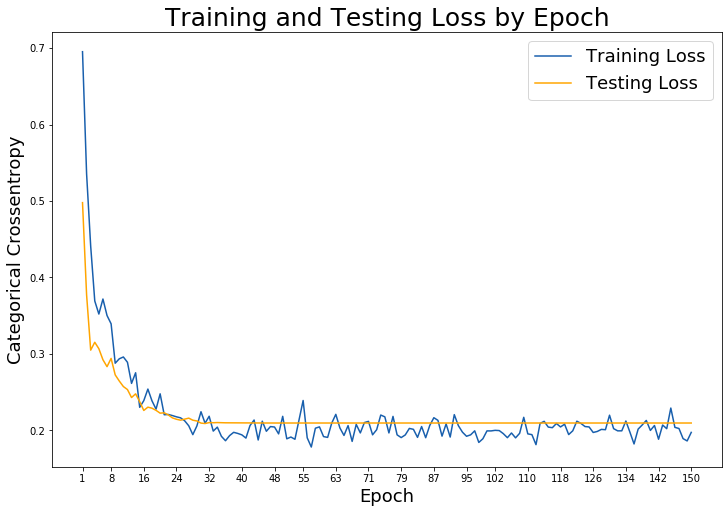

In [23]:
ticks_1 = (np.linspace(0, epochs-1, 20).astype(int))
ticks_2 = (np.linspace(1, epochs, 20).astype(int))

# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(ticks_1, ticks_2)
plt.legend(fontsize = 18);

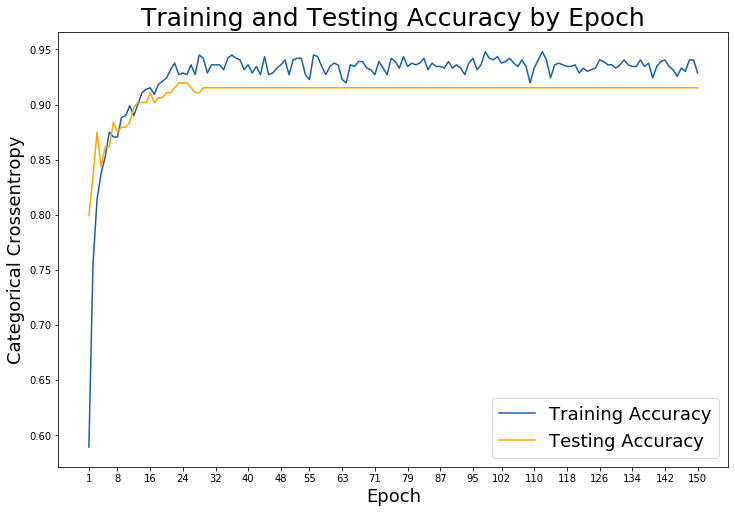

In [24]:
ticks_1 = (np.linspace(0, epochs-1, 20).astype(int))
ticks_2 = (np.linspace(1, epochs, 20).astype(int))

# Check out our train accuracy and accuracy loss over epochs.
train_loss = history.history['acc']
test_loss = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing accuracy over epochs.
plt.plot(train_loss, label='Training Accuracy', color='#185fad')
plt.plot(test_loss, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(ticks_1, ticks_2)
plt.legend(fontsize = 18);

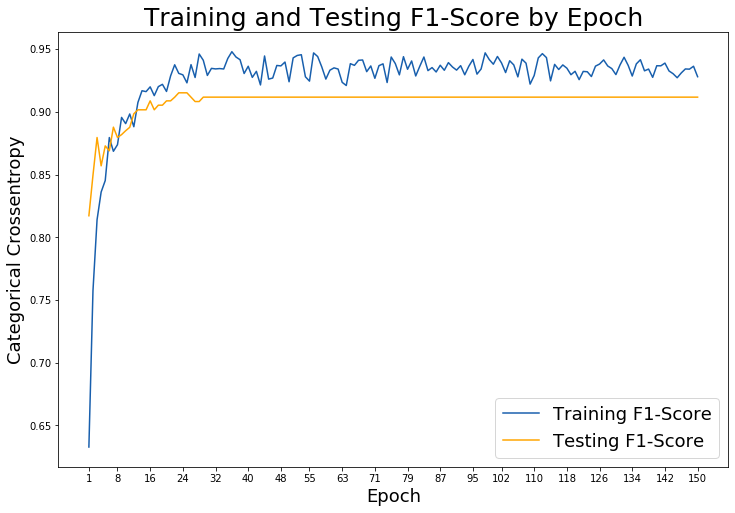

In [27]:
ticks_1 = (np.linspace(0, epochs-1, 20).astype(int))
ticks_2 = (np.linspace(1, epochs, 20).astype(int))

# Check out our train accuracy and accuracy loss over epochs.
train_loss = history.history['f1']
test_loss = history.history['val_f1']

# Set figure size.
plt.figure(figsize=(12, 8))

# Gaenerate line plot of training, testing accuracy over epochs.
plt.plot(train_loss, label='Training F1-Score', color='#185fad')
plt.plot(test_loss, label='Testing F1-Score', color='orange')

# Set title
plt.title('Training and Testing F1-Score by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(ticks_1, ticks_2)
plt.legend(fontsize = 18);

In [17]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


model.compile(loss='binary_crossentropy',
          optimizer= "adam",
          metrics=[f1])

W0824 18:08:40.276521 4574500288 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0824 18:08:40.330250 4574500288 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0824 18:08:40.340133 4574500288 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [39]:
test_master_w_predictions = pd.merge(test_master, predicted_player_nn, left_on='Player_name', right_on='Player_name')
test_master_w_predictions = pd.merge(test_master_w_predictions, predicted_player, left_on='Player_name', right_on='Player_name')

test_master_w_predictions.head()

,Player_name,player_id,SEASON,Tm_x,DRAFT_YEAR+1_x,Draft_team,Pk,Pos,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,College,Yrs,PTS,TRB,AST,FG%,3P%,FT%,PPG,RPG,APG,draft_round,target,DRAFT_YEAR+1_y,neural,DRAFT_YEAR+1,lr_class,forest_class,tree_class,ada_class,knn_class,bag_class,svc,grad,tot
0,Bam Adebayo,adebaba01,2019,MIA,2018.0,MIA,14.0,C,21,82,1913,17.9,0.623,0.031,0.465,9.2,24.0,16.6,14.2,1.8,3.0,17.1,15.8,3.4,3.4,6.8,0.171,-0.6,3.6,3.0,2.4,University of Kentucky,2.0,1206.0,978.0,285.0,0.550,0.136,0.728,8.0,6.5,1.9,1.0,0,2018.0,1,2018.0,1,0,1,0,0,1,0,0,3
1,Jarrett Allen,allenja01,2019,BRK,2018.0,BRK,22.0,C,20,80,2096,18.5,0.632,0.079,0.489,9.6,24.0,16.8,7.9,1.0,4.5,13.0,15.9,4.4,3.3,7.6,0.175,-0.7,3.2,2.5,2.4,University of Texas at Austin,2.0,1460.0,1060.0,159.0,0.590,0.183,0.732,9.6,7.0,1.0,1.0,0,2018.0,1,2018.0,1,0,1,0,0,1,0,0,3
2,Kadeem Allen,allenka01,2019,NYK,2018.0,BOS,53.0,SG,26,19,416,16.2,0.574,0.255,0.383,2.0,11.1,6.4,28.7,1.9,0.8,13.6,19.6,0.7,0.2,1.0,0.111,0.5,-1.6,-1.1,0.1,University of Arizona,2.0,208.0,62.0,88.0,0.436,0.362,0.778,5.6,1.7,2.4,2.0,0,2018.0,0,2018.0,0,0,0,0,0,0,0,0,0
3,Ike Anigbogu,anigbik01,2019,IND,2018.0,IND,47.0,C,20,3,6,-6.0,0.000,0.000,0.000,18.9,36.2,27.7,19.4,0.0,14.8,25.0,29.1,-0.1,0.0,-0.1,-0.480,-22.5,8.5,-14.0,0.0,University of California Los Angeles,2.0,13.0,12.0,1.0,0.333,NaN,0.833,0.9,0.9,0.1,2.0,0,2018.0,0,2018.0,0,0,0,0,0,1,0,0,1
4,OG Anunoby,anunoog01,2019,TOR,2018.0,TOR,23.0,SF,21,67,1352,9.8,0.544,0.500,0.153,4.8,10.8,7.9,4.7,1.6,1.3,11.3,15.5,0.3,1.7,2.0,0.070,-1.3,0.1,-1.2,0.3,Indiana University,2.0,907.0,381.0,102.0,0.461,0.351,0.605,6.4,2.7,0.7,1.0,0,2018.0,0,2018.0,0,0,0,0,0,0,0,0,0


In [52]:
fig = px.scatter_3d(test_master_w_predictions, x='BPM', y='WS', z='Age',
              color='tot', hover_name='Player_name', hover_data=['USG%', 'PER', 'MP', 'VORP', 'Age'])
fig.update_layout(scene=dict(xaxis=dict(range=[-15,10],),))
fig.show()


In [69]:
fig = px.scatter(test_master_w_predictions, x='BPM', y='WS',
              color='neural', hover_name='Player_name', hover_data=['USG%', 'PER', 'MP', 'VORP', 'Age'], color_continuous_scale=px.colors.diverging.PiYG)
fig.update_xaxes(range=[-15, 4.5])
fig.show()


In [84]:
fig = px.scatter(test_master_w_predictions, x='WS', y='VORP',
              color='neural', hover_name='Player_name', hover_data=['USG%', 'PER', 'MP', 'VORP', 'Age', 'RPG'], color_continuous_scale=px.colors.diverging.PiYG)
# fig.update_xaxes(range=[-2, 4.5])
fig.show()


In [79]:
test_master_w_predictions.corr()[['tot', 'neural']].sort_values('neural', ascending=False)

# values.corr()[['SalePrice']].sort_values('SalePrice', ascending=False).head(77)

,tot,neural
neural,0.801986,1.000000
tot,1.000000,0.801986
lr_class,0.804666,0.778312
bag_class,0.849738,0.700534
forest_class,0.872303,0.673500
tree_class,0.840365,0.672328
grad,0.853578,0.664964
WS,0.648341,0.642565
ada_class,0.796165,0.601298
OWS,0.625554,0.572020
